# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Если вы выбрали pix2pix
---------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для pix2pix модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все безплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Если вы выбрали CycleGAN
--------------------------------------------
Здесь от вас ожидается, что вы реализуете свою архитектуру для CycleGAN модели. Пожалуйста не копируйте код из открытых репозиториев. Этот факт очень легко обнаружить. Перед тем, как приступить проверьте, что обе задачи, которые вы выбрали влезают на вашу видеокарту или на карту Google Colab. CycleGAN в этом смысле хуже, чем pix2pix, он ест больше памяти. Если они не влезают, но вам все равно очень хочется, то вы можете израсходовать все беcплатные триалы облаков(Google, Amazon, .. etc) во вселенной. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
!unzip /content/gdrive/My\ Drive/DL\ School/Homeworks/GAN\ and\ Transfer\ Style/maps/train -d train
!unzip /content/gdrive/My\ Drive/DL\ School/Homeworks/GAN\ and\ Transfer\ Style/maps/val -d val

In [0]:
import pickle
import numpy as np
from skimage import io
from IPython.display import clear_output
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline
import random
import cv2
# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [0]:
class ImageDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        #add augmentation
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = transform(x)
        return x
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE*2, RESCALE_SIZE))             
        return np.array(image)

In [0]:
# разные режимы датасета 
DATA_MODES = ['train', 'val']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 256
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [0]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [0]:
TRAIN_DIR = Path('train')
VAL_DIR = Path('val')
train_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
val_files = sorted(list(VAL_DIR.rglob('*.jpg')))

In [0]:
val_dataset = ImageDataset(val_files, mode='val')
train_dataset = ImageDataset(train_files, mode='train')

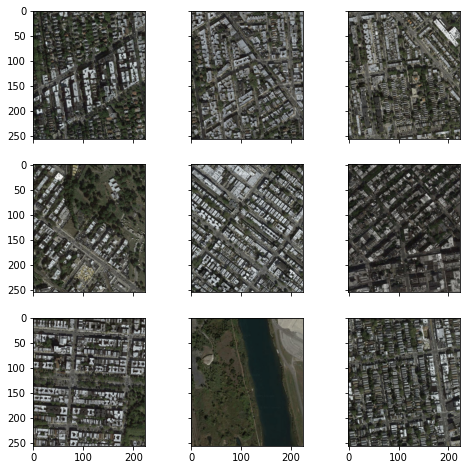

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val = val_dataset[random_characters]
    imshow(im_val[:, :, :224],plt_ax=fig_x)

torch.Size([3, 256, 512])
torch.Size([3, 256, 512])


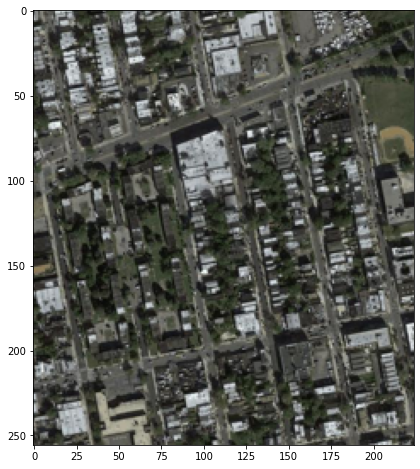

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8, 8), \
                        sharey=True, sharex=True)
random_characters = int(np.random.uniform(0,1000))
im_val = val_dataset[0]
print(im_val.shape)
imshow(im_val[:, :, :224],plt_ax=ax)
print(im_val.shape)

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, 4, 2, 1)
    self.conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128))
    self.conv3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256))
    self.conv4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512))
    self.conv5 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512))
    self.conv6 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512))
    self.conv7 = nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512))
    self.conv8 = nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1)

    self.deconv1 = nn.Sequential(nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512))
    self.deconv2 = nn.Sequential(nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512))
    self.deconv3 = nn.Sequential(nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512))
    self.deconv4 = nn.Sequential(nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512))
    self.deconv5 = nn.Sequential(nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256))
    self.deconv6 = nn.Sequential(nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128))
    self.deconv7 = nn.Sequential(nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(64))
    self.deconv8 = nn.ConvTranspose2d(128, 3, kernel_size=4, stride=2, padding=1)

  def forward(self, input):
    e1 = self.conv1(input)
    e2 = self.conv2(F.leaky_relu(e1, 0.2))
    e3 = self.conv3(F.leaky_relu(e2, 0.2))
    e4 = self.conv4(F.leaky_relu(e3, 0.2))
    e5 = self.conv5(F.leaky_relu(e4, 0.2))
    e6 = self.conv6(F.leaky_relu(e5, 0.2))
    e7 = self.conv7(F.leaky_relu(e6, 0.2))
    e8 = self.conv8(F.leaky_relu(e7, 0.2))

    d1 = torch.cat([F.dropout(self.deconv1(F.relu(e8)), 0.5), e7], 1)
    d2 = torch.cat([F.dropout(self.deconv2(F.relu(d1)), 0.5), e6], 1)
    d3 = torch.cat([F.dropout(self.deconv3(F.relu(d2)), 0.5), e5], 1)
    d4 = torch.cat([F.dropout(self.deconv4(F.relu(d3)), 0.5), e4], 1)
    d5 = torch.cat([F.dropout(self.deconv5(F.relu(d4)), 0.5), e3], 1)
    d6 = torch.cat([F.dropout(self.deconv6(F.relu(d5)), 0.5), e2], 1)
    d7 = torch.cat([F.dropout(self.deconv7(F.relu(d6)), 0.5), e1], 1)
    d8 = torch.tanh(self.deconv8(F.relu(d7)))

    return d8

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(6, 64, 4, 2, 1)
    self.conv2 = nn.Sequential(nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128))
    self.conv3 = nn.Sequential(nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256))
    self.conv4 = nn.Sequential(nn.Conv2d(256, 512, 4, 1, 1), nn.BatchNorm2d(512))
    self.conv5 = nn.Conv2d(512, 2, 4, 1, 1)

  def forward(self, input, label):
    r1 = torch.cat([input, label], 1)
    r2 = F.leaky_relu(self.conv1(r1), 0.2)
    r3 = F.leaky_relu(self.conv2(r2), 0.2)
    r4 = F.leaky_relu(self.conv3(r3), 0.2)
    r5 = F.leaky_relu(self.conv4(r4), 0.2)
    r6 = torch.sigmoid(self.conv5(r5))

    return r6

In [0]:
G = Generator().to(DEVICE)
D = Discriminator().to(DEVICE)

In [16]:
import torchsummary
torchsummary.summary(G.cuda(), (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           3,136
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 16, 16]       2,097,664
       BatchNorm2d-7          [-1, 512, 16, 16]           1,024
            Conv2d-8            [-1, 512, 8, 8]       4,194,816
       BatchNorm2d-9            [-1, 512, 8, 8]           1,024
           Conv2d-10            [-1, 512, 4, 4]       4,194,816
      BatchNorm2d-11            [-1, 512, 4, 4]           1,024
           Conv2d-12            [-1, 512, 2, 2]       4,194,816
      BatchNorm2d-13            [-1, 512, 2, 2]           1,024
           Conv2d-14            [-1, 51

In [17]:
torchsummary.summary(D.cuda(), [(3, 256, 256) , (3, 256, 256)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,208
            Conv2d-2          [-1, 128, 64, 64]         131,200
       BatchNorm2d-3          [-1, 128, 64, 64]             256
            Conv2d-4          [-1, 256, 32, 32]         524,544
       BatchNorm2d-5          [-1, 256, 32, 32]             512
            Conv2d-6          [-1, 512, 31, 31]       2,097,664
       BatchNorm2d-7          [-1, 512, 31, 31]           1,024
            Conv2d-8            [-1, 2, 30, 30]          16,386
Total params: 2,777,794
Trainable params: 2,777,794
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 147456.00
Forward/backward pass size (MB): 27.52
Params size (MB): 10.60
Estimated Total Size (MB): 147494.12
----------------------------------------------------------------


In [0]:
epochs = 250
BCE_loss = nn.BCELoss().to(DEVICE)
L1_loss = nn.L1Loss().to(DEVICE)
#GAN_loss = nn.DCGANLoss().to(DEVICE)
batch_size = 32
D_optimizer = torch.optim.Adam(D.parameters(), lr = 2e-4, betas=(0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr = 2e-4, betas=(0.5, 0.999))
train_hist = {}
train_hist['D_losses'] = []
train_hist['G_losses'] = []
train_hist['per_epoch_ptimes'] = []
train_hist['total_ptime'] = []
D_scheduler = torch.optim.lr_scheduler.StepLR(D_optimizer, step_size=50, gamma=0.5)
G_scheduler = torch.optim.lr_scheduler.StepLR(G_optimizer, step_size=50, gamma=0.5)

In [19]:
from torch.autograd import Variable
import time
G.train()
D.train()
for i in range(epochs):
  D_losses = []
  G_losses = []
  epoch_start_time = time.time()
  num_iter = 0
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
  for x in train_loader:
    D.zero_grad()
    x_ = x[:, :, :, 256:]
    y_ = x[:, :, :, :256]
    x_, y_ = Variable(x_.cuda()), Variable(y_.cuda())
    D_result = D(x_, y_).squeeze()
    D_real_loss = BCE_loss(D_result, Variable(torch.ones(D_result.size()).cuda()))
    G_result = G(x_)
    D_result = D(x_, G_result).squeeze()
    D_fake_loss = BCE_loss(D_result, Variable(torch.zeros(D_result.size()).cuda()))

    D_train_loss = (D_real_loss + D_fake_loss) * 0.5
    D_train_loss.backward()
    D_optimizer.step()
    train_hist['D_losses'].append(D_train_loss.item())
    D_losses.append(D_train_loss.item())

        # train generator G
    G.zero_grad()

    G_result = G(x_)
    D_result = D(x_, G_result).squeeze()
    #print(BCE_loss(G_result, y_), BCE_loss(D_result, Variable(torch.ones(D_result.size()).cuda())), L1_loss(G_result, y_))
    G_train_loss = BCE_loss(D_result, Variable(torch.ones(D_result.size()).cuda())) / 100 +  L1_loss(G_result, y_)
    G_train_loss.backward()
    G_optimizer.step()
    train_hist['G_losses'].append(G_train_loss.item())

    G_losses.append(G_train_loss.item())
    num_iter += 1
  D_scheduler.step()
  G_scheduler.step()
  epoch_end_time = time.time()
  per_epoch_ptime = epoch_end_time - epoch_start_time
  print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((i + 1), epochs, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))

[1/250] - ptime: 33.93, loss_d: 0.324, loss_g: 0.636
[2/250] - ptime: 33.81, loss_d: 0.018, loss_g: 0.534
[3/250] - ptime: 33.75, loss_d: 0.007, loss_g: 0.530
[4/250] - ptime: 33.80, loss_d: 0.004, loss_g: 0.531
[5/250] - ptime: 33.61, loss_d: 0.003, loss_g: 0.535
[6/250] - ptime: 33.77, loss_d: 0.002, loss_g: 0.534
[7/250] - ptime: 33.78, loss_d: 0.001, loss_g: 0.537
[8/250] - ptime: 33.68, loss_d: 0.001, loss_g: 0.537
[9/250] - ptime: 34.09, loss_d: 0.001, loss_g: 0.536
[10/250] - ptime: 33.78, loss_d: 0.001, loss_g: 0.539
[11/250] - ptime: 33.80, loss_d: 0.001, loss_g: 0.538
[12/250] - ptime: 33.77, loss_d: 0.001, loss_g: 0.540
[13/250] - ptime: 33.82, loss_d: 1.101, loss_g: 0.519
[14/250] - ptime: 33.92, loss_d: 0.367, loss_g: 0.478
[15/250] - ptime: 33.56, loss_d: 0.048, loss_g: 0.500
[16/250] - ptime: 33.87, loss_d: 0.083, loss_g: 0.504
[17/250] - ptime: 33.76, loss_d: 0.024, loss_g: 0.512
[18/250] - ptime: 33.75, loss_d: 0.005, loss_g: 0.516
[19/250] - ptime: 33.69, loss_d: 0.00

In [21]:
G.eval()
D.eval()
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(len(val_loader))
for x in val_loader:
    x_ = x[:, :, :, 256:]
    y_ = x[:, :, :, :256]
    x_, y_ = Variable(x_.cuda()), Variable(y_.cuda())
    test_image = G(x_)
    fig, ax = plt.subplots(1, 3, figsize=(16, 16))
    imshow(test_image[0].data.cpu(), plt_ax=ax[0])
    imshow(y_[0].data.cpu(), plt_ax=ax[1])
    imshow(x_[0].data.cpu(), plt_ax=ax[2])

Output hidden; open in https://colab.research.google.com to view.